<a href="https://colab.research.google.com/github/Zezo-Elkafoury/Food-Classifier-API-DL/blob/main/Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install datasets

In [28]:
from datasets import load_dataset

# Loading Data

In [29]:
data=load_dataset('food101',split='train[:5000]')

### Inspecting the data

In [30]:
data

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

## Splitting Data

In [31]:
data=data.train_test_split(test_size=0.2)

In [32]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

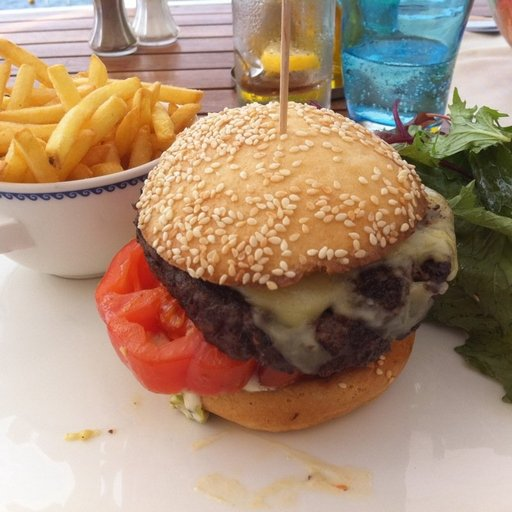

In [33]:
data['train'][0]['image']

## Mapping Labels

In [34]:
labels=data['train'].features['label'].names
label2id,id2label={},{}
for i, label in enumerate(labels):
    label2id[label]=i
    id2label[i]=label

In [35]:
id2label

{0: 'apple_pie',
 1: 'baby_back_ribs',
 2: 'baklava',
 3: 'beef_carpaccio',
 4: 'beef_tartare',
 5: 'beet_salad',
 6: 'beignets',
 7: 'bibimbap',
 8: 'bread_pudding',
 9: 'breakfast_burrito',
 10: 'bruschetta',
 11: 'caesar_salad',
 12: 'cannoli',
 13: 'caprese_salad',
 14: 'carrot_cake',
 15: 'ceviche',
 16: 'cheesecake',
 17: 'cheese_plate',
 18: 'chicken_curry',
 19: 'chicken_quesadilla',
 20: 'chicken_wings',
 21: 'chocolate_cake',
 22: 'chocolate_mousse',
 23: 'churros',
 24: 'clam_chowder',
 25: 'club_sandwich',
 26: 'crab_cakes',
 27: 'creme_brulee',
 28: 'croque_madame',
 29: 'cup_cakes',
 30: 'deviled_eggs',
 31: 'donuts',
 32: 'dumplings',
 33: 'edamame',
 34: 'eggs_benedict',
 35: 'escargots',
 36: 'falafel',
 37: 'filet_mignon',
 38: 'fish_and_chips',
 39: 'foie_gras',
 40: 'french_fries',
 41: 'french_onion_soup',
 42: 'french_toast',
 43: 'fried_calamari',
 44: 'fried_rice',
 45: 'frozen_yogurt',
 46: 'garlic_bread',
 47: 'gnocchi',
 48: 'greek_salad',
 49: 'grilled_chees

In [36]:
label2id

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheesecake': 16,
 'cheese_plate': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

# Preprocessing Images

In [37]:
! pip install --upgrade transformers

In [38]:
from transformers import AutoImageProcessor

In [39]:
processor=AutoImageProcessor.from_pretrained('google/vit-base-patch16-224') #importing the processing needed for the model

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Getting image dimensions for the pretrained model

In [40]:
size=(processor.size['height'],processor.size['width'])
size

(224, 224)

In [41]:
!pip install torchvision

In [42]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
transform=Compose([
    RandomResizedCrop(size),
    ToTensor(),
    Normalize(mean=processor.image_mean,std=processor.image_std)
])

In [43]:
def proccess_images(samples):
  samples['pixel_values']=[transform(img.convert('RGB')) for img in samples['image'] ]
  del samples['image']
  return samples

In [44]:
data_final=data.with_transform(proccess_images) # applying transformation on the data

# Model Training

In [45]:
from transformers import AutoModelForImageClassification, Trainer, TrainingArguments
model= AutoModelForImageClassification.from_pretrained('google/vit-base-patch16-224',
                                                            num_labels=len(labels),
                                                            id2label=id2label,
                                                            label2id=label2id,
                                                            ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from transformers import DefaultDataCollator
data_collator=DefaultDataCollator()

In [47]:
!pip install evaluate

In [48]:
import evaluate
import numpy as np
metric=evaluate.load('accuracy')
def compute_metrices(predictions_and_labels):
  predictions,labels=predictions_and_labels
  predictions=np.argmax(predictions,axis=1)
  return metric.compute(predictions=predictions,references=labels)

In [49]:
from huggingface_hub import notebook_login

notebook_login()

In [53]:
training_args=TrainingArguments(
    output_dir='./food_model',
    run_name='food_classification_experiment',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=10,
    metric_for_best_model='accuracy',
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=2,
    push_to_hub=True, # To publish the model on huggingface
    remove_unused_columns=False,
    load_best_model_at_end=True
)

In [55]:
trainer=Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data_final['train'],
    eval_dataset=data_final['test'],
    processing_class=processor,
    compute_metrics=compute_metrices,
)

In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.363600,0.271587,0.909000
2,0.282300,0.238920,0.922000
3,0.079800,0.218053,0.930000
4,0.049000,0.191557,0.938000
5,0.075000,0.217192,0.937000
6,0.209800,0.239883,0.935000
7,0.064400,0.251141,0.933000
8,0.079100,0.199641,0.944000
9,0.077000,0.235836,0.937000
10,0.047900,0.205793,0.951000


TrainOutput(global_step=2500, training_loss=0.11514055730998517, metrics={'train_runtime': 1806.7861, 'train_samples_per_second': 22.139, 'train_steps_per_second': 1.384, 'total_flos': 3.102429947904e+18, 'train_loss': 0.11514055730998517, 'epoch': 10.0})

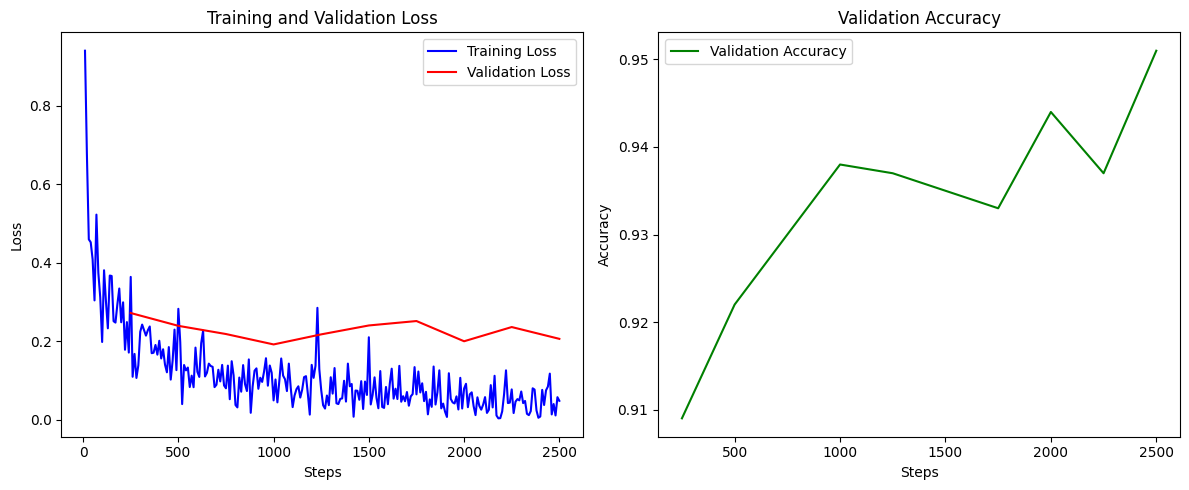

In [57]:
import matplotlib.pyplot as plt

# Initialize lists
train_loss = []
train_steps = []

eval_loss = []
eval_accuracy = []
eval_steps = []

# Extract values
for log in trainer.state.log_history:
    if 'loss' in log and 'step' in log:
        train_loss.append(log['loss'])
        train_steps.append(log['step'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
        eval_accuracy.append(log['eval_accuracy'])
        eval_steps.append(log['step'])


plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(eval_steps, eval_loss, label='Validation Loss', color='red')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Inference System and API

In [4]:
!pip install FastAPI
!pip install uvicorn
!pip install python-multipart
!pip install aiofiles

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.5 MB/s eta 0:00:00


In [5]:
from fastapi import FastAPI, File, UploadFile
from typing import List
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
import io

app = FastAPI()

# Load the pre-trained processor and model
processor = AutoImageProcessor.from_pretrained("ZiadElkafoury/food_model")
model = AutoModelForImageClassification.from_pretrained("ZiadElkafoury/food_model")


@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    """
    Predicts the food item in an uploaded image.

    Args:
        file (UploadFile): The image file to be processed.

    Returns:
        dict: A dictionary containing the predicted label.
    """
    try:
        # Read the image file
        contents = await file.read()
        image = Image.open(io.BytesIO(contents)).convert("RGB")

        # Preprocess the image
        inputs = processor(images=image, return_tensors="pt")

        # Make the prediction
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the predicted label
        predicted_label_id = outputs.logits.argmax(-1).item()
        predicted_label = model.config.id2label[predicted_label_id]

        # Return the prediction
        return {"predicted_label": predicted_label}

    except Exception as e:
        return {"error": str(e)}